In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import warnings
from datetime import datetime
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from scipy.stats import shapiro
from scipy.stats import kstest
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import t as t_dist
from arch import arch_model
from matplotlib.lines import Line2D


warnings.filterwarnings("ignore")

# DIRECTORY

In [2]:
directory = pd.read_excel('DATASET_1.xlsx')

In [3]:
directory.head()

,Ticker BBG,Ticker,Region,GICS Ind Grp Name\n,Index
0,ENX FP Equity,ENX,FP,Financial Services,0
1,PSPN SE Equity,PSPN,SE,Real Estate Management & Development,1
2,BOL SS Equity,BOL,SS,Materials,2
3,SOI FP Equity,SOI,FP,Semiconductors & Semiconductor Equipment,3
4,URW FP Equity,URW,FP,Equity Real Estate Investment Trusts (REITs),4


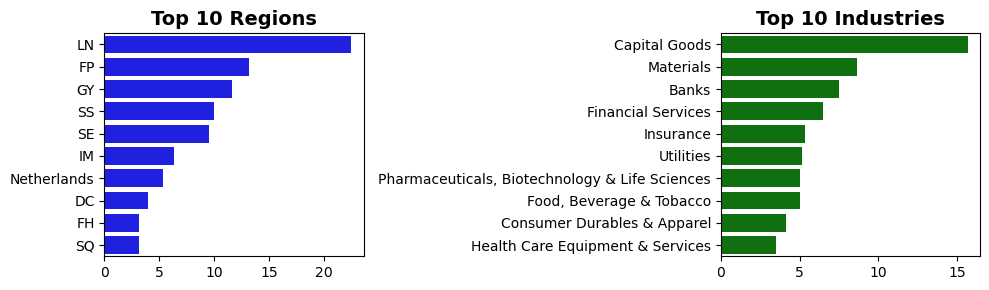

In [4]:
top_regions = directory['Region'].value_counts(normalize=True).mul(100).head(10).reset_index()
top_regions.columns = ['Region', 'Percentage']

top_industries = directory['GICS Ind Grp Name\n'].value_counts(normalize=True).mul(100).head(10).reset_index()
top_industries.columns = ['GICS Ind Grp Name\n', 'Percentage']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

sns.barplot(x='Percentage', y='Region', data=top_regions, ax=axes[0], color='blue')
axes[0].set_title('Top 10 Regions', fontsize=14, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('')

sns.barplot(x='Percentage', y='GICS Ind Grp Name\n', data=top_industries, ax=axes[1], color='green')
axes[1].set_title('Top 10 Industries', fontsize=14, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# GERMAN TWIN BONDS

In [5]:
twin_bonds = pd.read_excel('DATASET_TWINBONDS.xlsx')
twin_bonds = twin_bonds.sort_values(by='Date')
twin_bonds = twin_bonds.dropna()

In [6]:
def calculate_ytm(price, maturity_date, current_date):
    par_value = 100  # Assuming the par value is $100
    n = (maturity_date - current_date).days / 365.25  # Calculate the number of years to maturity
    ytm = (par_value / price) ** (1 / n) - 1
    return ytm * 100  # Convert to percentage

maturity_date_1 = datetime(2030, 8, 15)
maturity_date_2 = datetime(2030, 8, 15)  # Assuming both bonds have the same maturity date

twin_bonds['YTM_DE0001030708'] = twin_bonds.apply(lambda row: calculate_ytm(row['DE0001030708'], maturity_date_1, row['Date']), axis=1)
twin_bonds['YTM_DE0001102507'] = twin_bonds.apply(lambda row: calculate_ytm(row['DE0001102507'], maturity_date_2, row['Date']), axis=1)

In [7]:
twin_bonds.head()

,Date,DE0001030708,DE0001102507,YTM_DE0001030708,YTM_DE0001102507
45,2020-09-30,105.543,105.316,-0.544949,-0.523257
44,2020-10-30,106.594,106.351,-0.650109,-0.626946
43,2020-11-30,105.972,105.723,-0.595855,-0.571758
42,2020-12-31,106.053,105.667,-0.608989,-0.571312
41,2021-01-29,105.785,105.397,-0.587682,-0.549389


In [8]:
twin_bonds['spread'] = twin_bonds['YTM_DE0001030708'] - twin_bonds['YTM_DE0001102507']

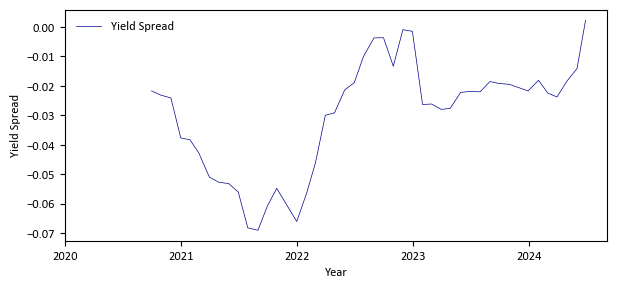

In [85]:
plt.figure(figsize=(7, 3))
sns.lineplot(x=twin_bonds['Date'], y=twin_bonds['spread'], label='Yield Spread', color='darkblue', linewidth=0.5)

plt.xlabel('Year', fontsize=9, fontname='Calibri')
plt.ylabel('Yield Spread', fontsize=9, fontname='Calibri')

years = twin_bonds['Date'].dt.year.unique()
plt.xticks(ticks=[pd.Timestamp(year=year, month=1, day=1) for year in years], 
           labels=[str(year) for year in years], 
           fontsize=9, fontname='Calibri')

plt.yticks(fontsize=9, fontname='Calibri')

legend_elements = [
    Line2D([0], [0], color='darkblue', linewidth=0.5, label='Yield Spread')
]

legend = plt.legend(handles=legend_elements, loc='upper left', fontsize=9, frameon=False)
plt.setp(legend.get_texts(), fontsize=9, fontname='Calibri')

plt.grid(False)
plt.show()

# MEASURING GREENNESS 

In [10]:
dataset_escore = pd.read_excel('DATASET_ESCORE.xlsx')
dataset_eweight = pd.read_excel('DATASET_EWEIGHT.xlsx')

dataset_escore = dataset_escore.fillna(method='bfill', axis=1)
dataset_eweight = dataset_eweight.fillna(method='bfill', axis=1)

dataset_escore = dataset_escore.drop(columns=['Ticker BBG'])
dataset_eweight = dataset_eweight.drop(columns=['Ticker BBG'])

In [11]:
greenness = - (10 - dataset_escore) * dataset_eweight / 100
greenness = greenness.apply(lambda col: col.fillna(col.mean()))
new_columns = {col: f'{2018 + i}' for i, col in enumerate(greenness.columns)}
greenness = greenness.rename(columns=new_columns)

In [12]:
dataset_marketcap = pd.read_excel('DATASET_MARKETCAP_2.xlsx')

dataset_marketcap = dataset_marketcap.fillna(method='bfill', axis=1)

In [13]:
annual_column = [2, 14, 26, 38, 50, 62]
dataset_marketcap_annual = dataset_marketcap.iloc[:, annual_column]
new_columns = {col: f'{2018 + i}' for i, col in enumerate(dataset_marketcap_annual.columns)}
dataset_marketcap_annual = dataset_marketcap_annual.rename(columns=new_columns)

In [14]:
weighted_avg_greenness = (dataset_marketcap_annual * greenness).sum(axis=0) / dataset_marketcap_annual.sum(axis=0)

weighted_avg_greenness = pd.DataFrame({
    'weighted_avg_greenness': weighted_avg_greenness.astype(float)
})

In [15]:
for col_idx, col_name in enumerate(greenness.columns):
    greenness[col_name] = greenness[col_name] - weighted_avg_greenness.iloc[col_idx, 0]
    
greenness['Ticker BBG'] = directory['Ticker BBG']

## RUN FOR SPECIFIC INDUSTRY

## GREEN AND BROWN COMPANIES INDEX

In [16]:
greenness_dfs = {f'greenness_{col}': greenness[['Ticker BBG', col]] for col in greenness.columns if col != 'Ticker BBG'}

for year, df in greenness_dfs.items():
    col_name = df.columns[1]
    quantile_33 = df[col_name].quantile(0.33)
    quantile_66 = df[col_name].quantile(0.66)
    
    # Label the data based on quantiles
    df['Label'] = pd.cut(df[col_name], bins=[-float('inf'), quantile_33, quantile_66, float('inf')], labels=['brown', 'grey', 'green'])
    
    # Create and assign DataFrames to variables in the global namespace
    globals()[f'directory_green_{col_name}'] = df[df['Label'] == 'green']
    globals()[f'directory_brown_{col_name}'] = df[df['Label'] == 'brown']

# REALIZED RETURN

## INDEXING

In [17]:
dataset_price = pd.read_excel('DATASET_PRICE_2.xlsx')

In [18]:
years = [2018, 2019, 2020, 2021, 2022, 2023]

for year in years:
    for color in ['green', 'brown']:
        directory_df = globals()[f'directory_{color}_{year}']
        price_df = dataset_price
        merged_df = pd.merge(directory_df, price_df, on='Ticker BBG', how='left')
        
        merged_df = merged_df.transpose().reset_index()
        
        merged_df.columns = merged_df.iloc[0]
        merged_df = merged_df[3:].reset_index()
        
        merged_df = merged_df.drop(columns=['Ticker BBG', 'index'])
        
        rr_df = merged_df.pct_change()
        
        rr_df = rr_df.apply(lambda row: row.fillna(row.mean()), axis=0)
        
        globals()[f'{color}_rr_{year}'] = rr_df

In [19]:
row_ranges = {
    2018: (0, 12),
    2019: (12, 24),
    2020: (24, 36),
    2021: (36, 48),
    2022: (48, 60),
    2023: (60, 72)
}

for year in years:
    for color in ['green', 'brown']:
        merged_df = globals()[f'{color}_rr_{year}']
        
        start_row, end_row = row_ranges[year]
        sliced_df = merged_df.iloc[start_row:end_row]
        
        globals()[f'{color}_rr_{year}'] = sliced_df

In [20]:
for year in years:
    for color in ['green', 'brown']:
        directory_df = globals()[f'directory_{color}_{year}']
        marketcap_df = dataset_marketcap
        merged_df = pd.merge(directory_df, marketcap_df, on='Ticker BBG', how='left')
        
        merged_df = merged_df.transpose().reset_index()
        
        merged_df.columns = merged_df.iloc[0]
        merged_df = merged_df[3:].reset_index()
        
        merged_df = merged_df.drop(columns=['Ticker BBG', 'index'])
        
        merged_df = merged_df.apply(lambda row: row.fillna(row.mean()), axis=0)
        
        globals()[f'{color}_marketcap_{year}'] = merged_df

In [21]:
for year in years:
    for color in ['green', 'brown']:
        merged_df = globals()[f'{color}_marketcap_{year}']
        
        start_row, end_row = row_ranges[year]
        sliced_df = merged_df.iloc[start_row:end_row]
        
        globals()[f'{color}_marketcap_{year}'] = sliced_df

In [22]:
for year in years:
    for color in ['green', 'brown']:
        rr_df = globals()[f'{color}_rr_{year}']
        marketcap_df = globals()[f'{color}_marketcap_{year}']
        
        portfolio_factor = (rr_df * marketcap_df).sum(axis=1) / marketcap_df.sum(axis=1)
        
        globals()[f'pf_{color}_{year}'] = portfolio_factor

In [23]:
months_per_year = 12  

pf_green_df = pd.DataFrame()
pf_brown_df = pd.DataFrame()

for year in years:
    pf_green = globals()[f'pf_green_{year}']
    pf_brown = globals()[f'pf_brown_{year}']
    
    pf_green_df = pd.concat([pf_green_df, pf_green], ignore_index=True)
    pf_brown_df = pd.concat([pf_brown_df, pf_brown], ignore_index=True)

GMB = pd.DataFrame({
    'pf_green': pf_green_df.values.flatten(),
    'pf_brown': pf_brown_df.values.flatten()
})

In [24]:
GMB['green_cs'] = GMB['pf_green'].cumsum()
GMB['brown_cs'] = GMB['pf_brown'].cumsum()
GMB['spread_cumsum'] = GMB['green_cs'] - GMB['brown_cs']
GMB['spread'] = GMB['pf_green'] - GMB['pf_brown']

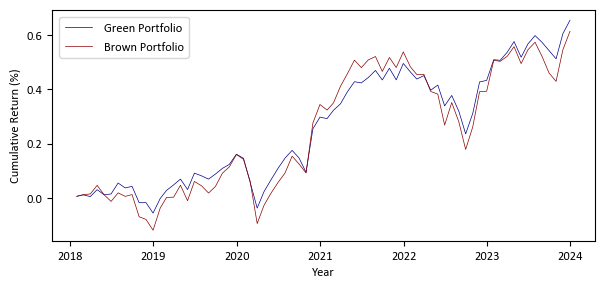

In [25]:
GMB['spread100'] = GMB['spread']*100
dates = pd.date_range(start='2018-01-01', periods=72, freq='M')

plt.figure(figsize=(7, 3))
sns.lineplot(x=dates, y=GMB['pf_green'].cumsum(), label='Green Portfolio', color='darkblue', linewidth=0.5)
sns.lineplot(x=dates, y=GMB['pf_brown'].cumsum(), label='Brown Portfolio', color='darkred', linewidth=0.5)
plt.xlabel('Year', fontsize=9, fontname='Calibri')
plt.ylabel('Cumulative Return (%)', fontsize=9, fontname='Calibri')

legend = plt.legend(loc='upper left')
plt.setp(legend.get_texts(), fontsize=9, fontname='Calibri')
plt.xticks(fontsize=9, fontname='Calibri')
plt.yticks(fontsize=9, fontname='Calibri')
plt.grid(False)
plt.show()

# STATISTICAL TEST

In [27]:
dataset_factors = pd.read_excel('DATASET_FACTORS.xlsx')

dataset_factors['GMB'] = GMB ['spread']

In [28]:
Y = dataset_factors['GMB']
X = dataset_factors[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit(cov_type='HC3')
predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMB   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     15.50
Date:                Thu, 01 Aug 2024   Prob (F-statistic):           8.75e-08
Time:                        13:49:15   Log-Likelihood:                 208.40
No. Observations:                  72   AIC:                            -408.8
Df Residuals:                      68   BIC:                            -399.7
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.643      0.5

# COST OF EQUITY

## COST OF EQUITY VIA BEST CONSENSUS

In [29]:
dataset_icc = pd.read_excel('DATASET_ROEBEST.xlsx')
dataset_icc = dataset_icc.fillna(method='bfill', axis=1)

dataset_marketcap_icc = dataset_marketcap_annual

In [30]:
new_columns = {col: f'icc_{2019 + i}' for i, col in enumerate(dataset_icc.columns)}
dataset_icc = dataset_icc.rename(columns=new_columns)
dataset_icc.rename(columns={'icc_2019': 'Ticker BBG'}, inplace=True)

In [31]:
dataset_marketcap_icc["2024"] = np.nan
dataset_marketcap_icc["2025"] = np.nan

years = np.array([2018, 2019, 2020, 2021, 2022, 2023]).reshape(-1, 1)

for index, row in dataset_marketcap_icc.iterrows():
    values = row[:6].values
    
    model = LinearRegression()
    model.fit(years, values)
    
    dataset_marketcap_icc.at[index, "2024"] = model.predict([[2024]])[0]
    dataset_marketcap_icc.at[index, "2025"] = model.predict([[2025]])[0]

dataset_marketcap_icc.drop(columns=["2018", "2019"], inplace=True)

In [32]:
dataset_marketcap_icc['Ticker BBG'] = directory['Ticker BBG']

directory_green_2024 = directory_green_2023
directory_green_2025 = directory_green_2023
directory_brown_2024 = directory_brown_2023
directory_brown_2025 = directory_brown_2023

In [33]:
years = [2020, 2021, 2022, 2023, 2024, 2025]
types = ['green', 'brown']

filtered_icc = {}

for year in years:
    for type_name in types:
        directory_column = f'directory_{type_name}_{year}'
        
        directory_df = globals()[directory_column]  
        
        filtered_icc_name = f'icc_{type_name}_{year}'
        filtered_icc[filtered_icc_name] = dataset_icc[dataset_icc['Ticker BBG'].isin(directory_df['Ticker BBG'])].copy()

for key, df in filtered_icc.items():
    globals()[key] = df 

In [34]:
new_columns = {col: f'mc_icc_{2020 + i}' for i, col in enumerate(dataset_marketcap_icc.columns)}
dataset_marketcap_icc = dataset_marketcap_icc.rename(columns=new_columns)
dataset_marketcap_icc.rename(columns={'mc_icc_2026': 'Ticker BBG'}, inplace=True)

In [35]:
filtered_marketcap_icc = {}

for year in years:
    for type_name in types:
        directory_column = f'directory_{type_name}_{year}'
        
        directory_df = globals()[directory_column]  
        
        filtered_marketcap_icc_name = f'marketcap_icc_{type_name}_{year}'
        filtered_marketcap_icc[filtered_marketcap_icc_name] = dataset_marketcap_icc[dataset_icc['Ticker BBG'].isin(directory_df['Ticker BBG'])].copy()

for key, df in filtered_marketcap_icc.items():
    globals()[key] = df  

In [36]:
years = range(2020, 2026) 

v_icc_green = {}


for year in years:
    icc_var_name = f'icc_green_{year}'
    mc_var_name = f'marketcap_icc_green_{year}'

    icc_data = globals()[icc_var_name] 
    mc_data = globals()[mc_var_name]    
    
    numerator = icc_data[f'icc_{year}'] * mc_data[f'mc_icc_{year}']
    denominator = mc_data[f'mc_icc_{year}']
    
    if denominator.sum() != 0:
        v_icc_green[year] = numerator.sum() / denominator.sum()
    else:
        v_icc_green[year] = 0  # Handle division by zero scenario

In [37]:
v_icc_brown = {}

for year in years:
    icc_var_name = f'icc_brown_{year}'
    mc_var_name = f'marketcap_icc_brown_{year}'

    icc_data = globals()[icc_var_name] 
    mc_data = globals()[mc_var_name]    
    
    icc_numeric = pd.to_numeric(icc_data[f'icc_{year}'], errors='coerce')
    mc_numeric = pd.to_numeric(mc_data[f'mc_icc_{year}'], errors='coerce')
    
    numerator = icc_numeric * mc_numeric
    denominator = mc_numeric
    
    if denominator.sum() != 0:
        v_icc_brown[year] = numerator.sum() / denominator.sum()
    else:
        v_icc_brown[year] = 0  

In [38]:
v_icc = pd.DataFrame({
    'year': list(v_icc_brown.keys()),
    'v_icc_brown': list(v_icc_brown.values()),
    'v_icc_green': list(v_icc_green.values())
})

v_icc['spread'] = v_icc['v_icc_green'] - v_icc['v_icc_brown']

## COST OF EQUITY VIA CAPM

## INDEXING

In [39]:
dataset_icc = pd.read_excel('DATASET_ICC.xlsx')
dataset_icc.rename(columns={'Dates': 'Ticker BBG'}, inplace=True)
dataset_icc = dataset_icc.fillna(method='bfill', axis=1)
dataset_icc = dataset_icc.fillna(method='ffill', axis=1)
#dataset_icc.head()

In [40]:
years = [2018, 2019, 2020, 2021, 2022, 2023]

for year in years:
    for color in ['green', 'brown']:
        directory_df = globals()[f'directory_{color}_{year}']
        icc_df = dataset_icc
        merged_df = pd.merge(directory_df, icc_df, on='Ticker BBG', how='left')
        
        merged_df = merged_df.transpose().reset_index()
        
        merged_df.columns = merged_df.iloc[0]
        merged_df = merged_df[3:].reset_index()
        
        merged_df = merged_df.drop(columns=['Ticker BBG', 'index'])

        globals()[f'{color}_icc_{year}'] = merged_df

In [41]:
for year in years:
    for color in ['green', 'brown']:
        merged_df = globals()[f'{color}_icc_{year}']
        
        start_row, end_row = row_ranges[year]
        sliced_df = merged_df.iloc[start_row:end_row]
        
        globals()[f'{color}_icc_{year}'] = sliced_df

In [42]:
for year in years:
    for color in ['green', 'brown']:
        icc_df = globals()[f'{color}_icc_{year}']
        marketcap_df = globals()[f'{color}_marketcap_{year}']
        
        icc_df = icc_df.apply(pd.to_numeric, errors='coerce')
        marketcap_df = marketcap_df.apply(pd.to_numeric, errors='coerce')
        
        icc_capm = (icc_df * marketcap_df).sum(axis=1) / marketcap_df.sum(axis=1)
        
        globals()[f'icc_{color}_{year}'] = icc_capm

In [43]:
icc_green_df = pd.DataFrame()
icc_brown_df = pd.DataFrame()

for year in years:
    icc_green = globals()[f'icc_green_{year}']
    icc_brown = globals()[f'icc_brown_{year}']
    
    icc_green_df = pd.concat([icc_green_df, icc_green], ignore_index=True)
    icc_brown_df = pd.concat([icc_brown_df, icc_brown], ignore_index=True)

wacc = pd.DataFrame({
    'icc_green': icc_green_df.values.flatten(),
    'icc_brown': icc_brown_df.values.flatten()
})

In [44]:
icc_summary = pd.read_excel('ICC_Summary.xlsx')
icc_summary.head()

,Date,CAPM,BEST
0,2018-01-01,-0.005066,0.104881
1,2019-01-01,-0.007025,0.099239
2,2020-01-01,-0.019436,0.069539
3,2021-01-01,-0.011154,0.069995
4,2022-01-01,-0.004847,0.102438


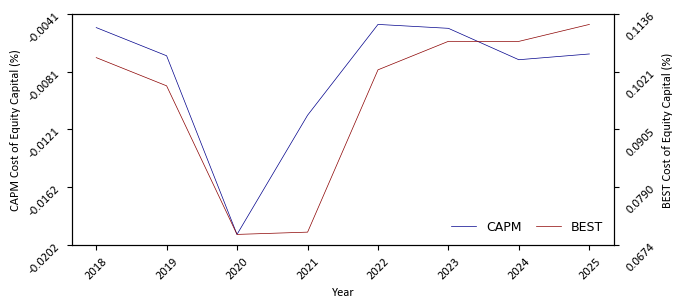

In [45]:
from matplotlib.ticker import FuncFormatter

def format_tick(value, tick_number):
    return f'{value:,.4f}'

fig, ax1 = plt.subplots(figsize=(7, 3))

sns.lineplot(x=icc_summary['Date'], y=icc_summary['CAPM'], label='CAPM', color='darkblue', linewidth=0.5, ax=ax1)
ax1.set_xlabel('Year', fontsize=9, fontname='Calibri', color='black')
ax1.set_ylabel('CAPM Cost of Equity Capital (%)', fontsize=9, fontname='Calibri', color='black')
ax1.tick_params(axis='y', labelsize=9, labelcolor='black')
ax1.tick_params(axis='x', labelsize=9, labelcolor='black', labelrotation=45)
ax1.grid(False)

ax1.set_yticks(np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], 5))
ax1.yaxis.set_major_formatter(FuncFormatter(format_tick))

ax2 = ax1.twinx()
sns.lineplot(x=icc_summary['Date'], y=icc_summary['BEST'], label='BEST', color='darkred', linewidth=0.5, ax=ax2)
ax2.set_ylabel('BEST Cost of Equity Capital (%)', fontsize=9, fontname='Calibri', color='black')
ax2.tick_params(axis='y', labelsize=9, labelcolor='black')
ax2.grid(False)

ax2.set_yticks(np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 5))
ax2.yaxis.set_major_formatter(FuncFormatter(format_tick))

ax1.tick_params(axis='both', which='major', labelsize=9, labelrotation=45)
ax2.tick_params(axis='both', which='major', labelsize=9, labelrotation=45)

for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontname('Calibri')
for label in ax2.get_yticklabels():
    label.set_fontname('Calibri')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

legend1 = ax1.legend(lines1, labels1, loc='lower right', fontsize=9, frameon=False, bbox_to_anchor=(0.85, 0))
legend2 = ax2.legend(lines2, labels2, loc='lower right', fontsize=9, frameon=False, bbox_to_anchor=(1, 0))

plt.show()

# DEMAND SHOCK

## CLIMATE RISK

In [46]:
dataset_mcci = pd.read_excel('DATASET_MCCI.xlsx')
dataset_mcci['Date'] = pd.to_datetime(dataset_mcci['Date'], format='%d/%m/%Y')

In [47]:
dataset_mcci['Aggregate_diff'] = dataset_mcci['Aggregate'].diff()
dataset_mcci.dropna(inplace = True)

In [48]:
test_size = 178
test_data = dataset_mcci['Aggregate_diff'].iloc[test_size:]
train_data = dataset_mcci['Aggregate_diff'].iloc[:test_size]

model = AutoReg(train_data, lags=1)
model_fit = model.fit()

# Print model summary
#print(model_fit.summary())

In [49]:
history = train_data.tolist()
predictions = []

for t in range(len(test_data)):
    model = AutoReg(history, lags=1)
    model_fit = model.fit()
    yhat = model_fit.predict(start=len(history), end=len(history), dynamic=False)
    predictions.append(yhat[0])
    history.append(test_data.iloc[t])

predictions_df = pd.DataFrame(predictions, index=test_data.index, columns=['Predicted_diff'])

es_df = dataset_mcci['Aggregate'].iloc[test_size:].to_frame().join(predictions_df)

es_df['Aggregate_lag1'] = es_df['Aggregate'].shift(1)
es_df['Aggregate_predict'] = es_df['Aggregate_lag1'] + es_df['Predicted_diff']
es_df.dropna(inplace = True)
es_df['mcci_error'] =  (es_df['Aggregate_predict'] - es_df['Aggregate']) 

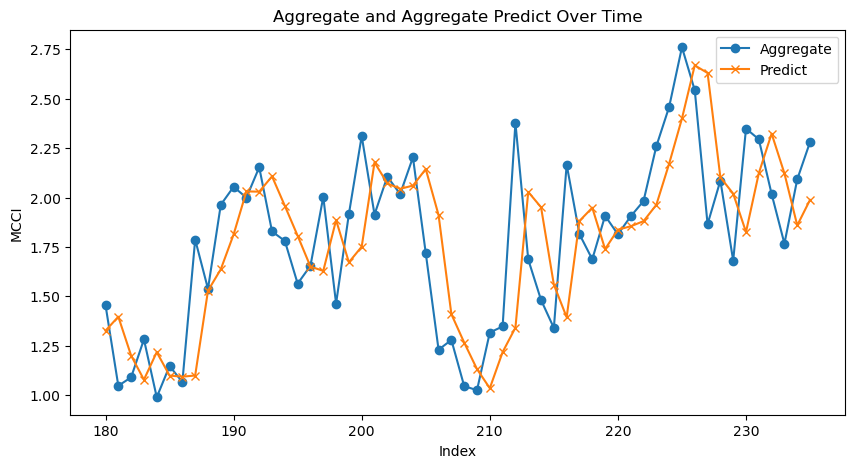

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(es_df.index, es_df['Aggregate'], label='Aggregate', marker='o')
plt.plot(es_df.index, es_df['Aggregate_predict'], label='Predict', marker='x')

plt.title('Aggregate and Aggregate Predict Over Time')
plt.xlabel('Index')
plt.ylabel('MCCI')
plt.legend()
plt.grid(False)
plt.show()

In [51]:
reg_df = pd.DataFrame()
reg_df['mcci_error'] = es_df['mcci_error']
reg_df.reset_index(inplace = True)
reg_df.drop(columns=['index'], inplace = True)

reg_df['gmb_spread'] = GMB['spread']
reg_df['pf_green'] = GMB['pf_green']
reg_df['pf_brown'] = GMB['pf_brown']
reg_df['Mkt-RF'] = dataset_factors['Mkt-RF']
reg_df['SMB'] = dataset_factors['SMB']
reg_df['HML'] = dataset_factors['HML']

## EARNINGS

In [52]:
dataset_eps = pd.read_excel('DATASET_EPS.xlsx')
dataset_epsest = pd.read_excel('DATASET_BESTEPS.xlsx')

dataset_eps = dataset_eps.drop(columns=['Dates'])
dataset_epsest = dataset_epsest.drop(columns=['Dates'])

e_shock = (dataset_eps - dataset_epsest) / dataset_epsest

In [53]:
def remove_outliers(row):
    non_nan_row = row.dropna()
    if non_nan_row.empty:
        return row 

    Q1 = np.percentile(non_nan_row, 25)
    Q3 = np.percentile(non_nan_row, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    cleaned_row = row.apply(lambda x: x if lower_bound <= x <= upper_bound else 0)
    
    return cleaned_row

e_shock = e_shock.apply(remove_outliers, axis=1)

e_shock = e_shock.fillna(0)
e_shock['Ticker BBG'] = directory['Ticker BBG']

In [54]:
years = [2018, 2019, 2020, 2021, 2022, 2023]

for year in years:
    for color in ['green', 'brown']:
        directory_df = globals()[f'directory_{color}_{year}']
        eshock_df = e_shock
        merged_df = pd.merge(directory_df, eshock_df, on='Ticker BBG', how='left')
        
        merged_df = merged_df.transpose().reset_index()
        
        merged_df.columns = merged_df.iloc[0]
        merged_df = merged_df[3:].reset_index()
        
        merged_df = merged_df.drop(columns=['Ticker BBG', 'index'])

        globals()[f'{color}_eshock_{year}'] = merged_df

In [55]:
for year in years:
    for color in ['green', 'brown']:
        merged_df = globals()[f'{color}_eshock_{year}']
        
        start_row, end_row = row_ranges[year]
        sliced_df = merged_df.iloc[start_row:end_row]
        sliced_df.replace([np.inf, -np.inf], 0, inplace=True)
        
        globals()[f'{color}_eshock_{year}'] = sliced_df

In [56]:
for year in years:
    for color in ['green', 'brown']:
        eshock_df = globals()[f'{color}_eshock_{year}']
        marketcap_df = globals()[f'{color}_marketcap_{year}']
                
        eshock = (eshock_df * marketcap_df).sum(axis=1) / marketcap_df.sum(axis=1)
        
        globals()[f'eshock_{color}_{year}'] = eshock

In [57]:
# Initialize empty DataFrames for pf_green and pf_brown
eshock_green_df = pd.DataFrame()
eshock_brown_df = pd.DataFrame()

for year in years:
    eshock_green = globals()[f'eshock_green_{year}']
    eshock_brown = globals()[f'eshock_brown_{year}']
    
    eshock_green_df = pd.concat([eshock_green_df, eshock_green], ignore_index=True)
    eshock_brown_df = pd.concat([eshock_brown_df, eshock_brown], ignore_index=True)

e_shock = pd.DataFrame({
    'eshock_green': eshock_green_df.values.flatten(),
    'eshock_brown': eshock_brown_df.values.flatten()
})    

e_shock['eshock_spread'] = e_shock['eshock_green'] - e_shock['eshock_brown'] 

In [58]:
date_range = pd.date_range(start='2018-01-01', periods=len(reg_df), freq='M')
reg_df['dates'] = date_range
reg_df['earnings_error'] = e_shock['eshock_spread']
reg_df['earnings_error_green'] = e_shock['eshock_green']
reg_df['earnings_error_brown'] = e_shock['eshock_brown']

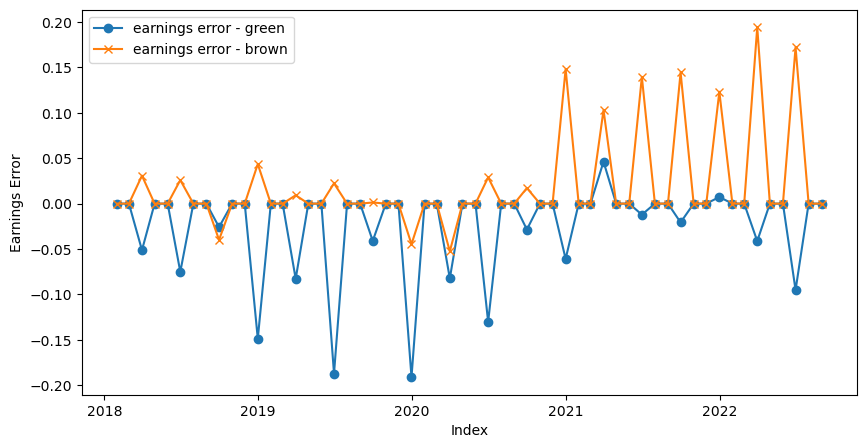

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(reg_df['dates'], reg_df['earnings_error_green'], label='earnings error - green', marker='o')
plt.plot(reg_df['dates'], reg_df['earnings_error_brown'], label='earnings error - brown', marker='x')

plt.xlabel('Index')
plt.ylabel('Earnings Error')
plt.legend()
plt.grid(False)
plt.show()

# STATIC ESSTIMATES OF GREEN PREMIUM

In [60]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   mcci_error            56 non-null     float64       
 1   gmb_spread            56 non-null     float64       
 2   pf_green              56 non-null     float64       
 3   pf_brown              56 non-null     float64       
 4   Mkt-RF                56 non-null     float64       
 5   SMB                   56 non-null     float64       
 6   HML                   56 non-null     float64       
 7   dates                 56 non-null     datetime64[ns]
 8   earnings_error        56 non-null     float64       
 9   earnings_error_green  56 non-null     float64       
 10  earnings_error_brown  56 non-null     float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 4.9 KB


In [61]:
Y = reg_df['gmb_spread']
X = reg_df[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit(cov_type='HC3')
predictions = model.predict(X)

In [62]:
residuals = model.resid
constant_term = model.params['const']
reg_df['alpha'] = residuals + constant_term

In [63]:
Y = reg_df['gmb_spread']
X = reg_df[['Mkt-RF', 'SMB', 'HML', 'mcci_error', 'earnings_error']]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit(cov_type='HC3')
predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             gmb_spread   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     6.370
Date:                Thu, 01 Aug 2024   Prob (F-statistic):           0.000119
Time:                        13:49:19   Log-Likelihood:                 160.11
No. Observations:                  56   AIC:                            -308.2
Df Residuals:                      50   BIC:                            -296.1
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0004      0.002     -0.

In [64]:
Y = reg_df['alpha']
X = reg_df[['mcci_error', 'earnings_error']]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit(cov_type='HC3')
predictions = model.predict(X)


residuals = model.resid
constant_term = model.params['const']
reg_df['alpha_2'] = residuals + constant_term

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  alpha   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                     1.307
Date:                Thu, 01 Aug 2024   Prob (F-statistic):              0.279
Time:                        13:49:19   Log-Likelihood:                 160.10
No. Observations:                  56   AIC:                            -314.2
Df Residuals:                      53   BIC:                            -308.1
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0004      0.002     -0.

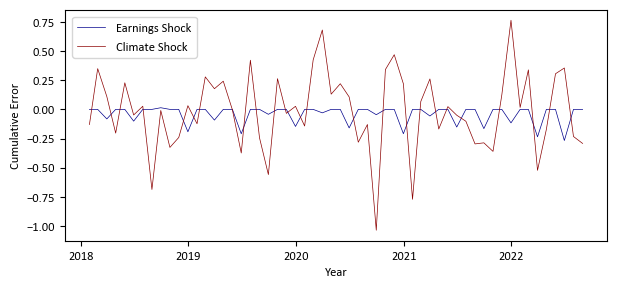

In [65]:
dates = pd.date_range(start='2018-01-01', periods=56, freq='M')

plt.figure(figsize=(7, 3))
sns.lineplot(x=dates, y=reg_df['earnings_error'], label='Earnings Shock', color='darkblue', linewidth=0.5)
sns.lineplot(x=dates, y=reg_df['mcci_error'], label='Climate Shock', color='darkred', linewidth=0.5)
plt.xlabel('Year', fontsize=9, fontname='Calibri')
plt.ylabel('Cumulative Error', fontsize=9, fontname='Calibri')
# plt.title('Time Series of Earnings Error and MCCI Error', fontsize=12, fontname='Calibri')

legend = plt.legend(loc='upper left')
plt.setp(legend.get_texts(), fontsize=9, fontname='Calibri')

plt.xticks(fontsize=9, fontname='Calibri')
plt.yticks(fontsize=9, fontname='Calibri')
plt.grid(False)
plt.show()

In [66]:
reg_df.head()

,mcci_error,gmb_spread,pf_green,pf_brown,Mkt-RF,SMB,HML,dates,earnings_error,earnings_error_green,earnings_error_brown,alpha,alpha_2
0,-0.130062,-0.000378,0.005477,0.005856,0.0552,0.0064,0.0110,2018-01-31,0.000000,0.000000,0.000000,0.012039,0.011853
1,0.349671,-0.000357,0.005499,0.005856,-0.0535,0.0110,-0.0075,2018-02-28,0.000000,0.000000,0.000000,-0.008553,-0.008053
2,0.109850,-0.009003,-0.006394,0.002609,-0.0071,-0.0056,-0.0094,2018-03-31,-0.082021,-0.051202,0.030819,-0.011581,-0.014157
3,-0.203841,-0.005990,0.025543,0.031533,0.0220,-0.0070,0.0151,2018-04-30,0.000000,0.000000,0.000000,-0.003320,-0.003612
4,0.228150,0.015868,-0.019018,-0.034886,-0.0273,0.0107,-0.0498,2018-05-31,0.000000,0.000000,0.000000,0.013376,0.013702


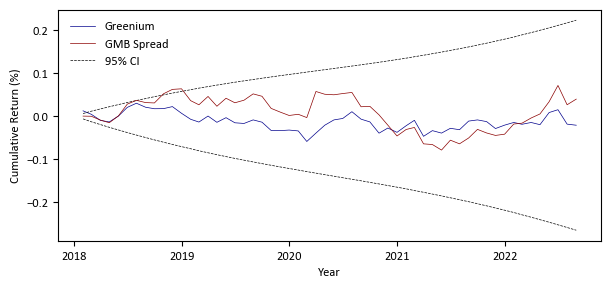

In [67]:
X = sm.add_constant(np.arange(len(reg_df)))
model = sm.OLS(reg_df['alpha_2'], X).fit()

# Get predictions and 95% confidence intervals
predictions = model.get_prediction(X)
ci = predictions.conf_int(alpha=0.1)  # 95% confidence interval

# Calculate the cumulative sum of alpha_2 and the confidence intervals
reg_df['alpha_2_cumsum'] = reg_df['alpha_2'].cumsum()
reg_df['lower_ci_cumsum'] = reg_df['alpha_2_cumsum'] + ci[:, 0].cumsum() - reg_df['alpha_2_cumsum']
reg_df['upper_ci_cumsum'] = reg_df['alpha_2_cumsum'] + ci[:, 1].cumsum() - reg_df['alpha_2_cumsum']
reg_df['gmb_spread_cumsum'] = reg_df['gmb_spread'].cumsum()

# Plotting
plt.figure(figsize=(7, 3))

# Plot the main line
sns.lineplot(x=reg_df['dates'], y=reg_df['alpha_2_cumsum'], label='Greenium', color='darkblue', linewidth=0.5)

# Plot the confidence interval as black lines
lower_ci_line, = plt.plot(reg_df['dates'], reg_df['lower_ci_cumsum'], color='black', linewidth=0.5, linestyle='dashed', label='95% CI')
upper_ci_line, = plt.plot(reg_df['dates'], reg_df['upper_ci_cumsum'], color='black', linewidth=0.5, linestyle='dashed')

# Plot the second line
sns.lineplot(x=reg_df['dates'], y=reg_df['gmb_spread_cumsum'], label='GMB Spread', color='darkred', linewidth=0.5)

plt.xlabel('Year', fontsize=9, fontname='Calibri')
plt.ylabel('Cumulative Return (%)', fontsize=9, fontname='Calibri')

# Customize the legend
legend_elements = [
    Line2D([0], [0], color='darkblue', linewidth=0.5, label='Greenium'),
    Line2D([0], [0], color='darkred', linewidth=0.5, label='GMB Spread'),
    Line2D([0], [0], color='black', linewidth=0.5, linestyle='dashed', label='95% CI')
]

legend = plt.legend(handles=legend_elements, loc='upper left', fontsize=9, frameon=False)
plt.setp(legend.get_texts(), fontsize=9, fontname='Calibri')
plt.xticks(fontsize=9, fontname='Calibri')
plt.yticks(fontsize=9, fontname='Calibri')
plt.grid(False)
plt.show()

# TIME SERIES ESSTIMATES OF GREEN PREMIUM

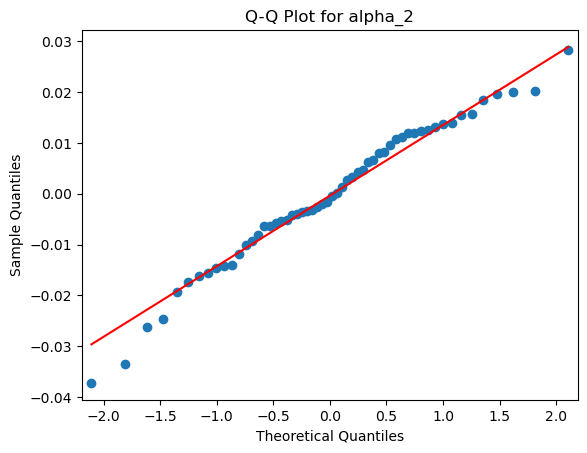

In [68]:
sm.qqplot(reg_df['alpha_2'], line='s')
plt.title('Q-Q Plot for alpha_2')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [69]:
X = sm.add_constant(X)  
y = reg_df['alpha_2']  

model = sm.OLS(y, X).fit()
residuals = model.resid

bp_test = het_breuschpagan(residuals, model.model.exog)

bp_test_statistic = bp_test[0]
bp_test_p_value = bp_test[1]

print(f'Breusch-Pagan Test Statistic: {bp_test_statistic}')
print(f'Breusch-Pagan Test p-value: {bp_test_p_value}')

white_test = het_white(residuals, model.model.exog)

white_test_statistic = white_test[0]
white_test_p_value = white_test[1]

print(f'White Test Statistic: {white_test_statistic}')
print(f'White Test p-value: {white_test_p_value}')

Breusch-Pagan Test Statistic: 1.9503168065695373
Breusch-Pagan Test p-value: 0.16255271589315945
White Test Statistic: 1.9549491018964087
White Test p-value: 0.37626012576528284


In [70]:
ks_test_statistic, ks_p_value = kstest(reg_df['alpha_2'], 'norm')

print(f'Kolmogorov-Smirnov Test Statistic: {ks_test_statistic}')
print(f'Kolmogorov-Smirnov Test p-value: {ks_p_value}')

shapiro_test_statistic, shapiro_p_value = shapiro(reg_df['alpha_2'])
print(f'Shapiro-Wilk Test Statistic: {shapiro_test_statistic}')
print(f'Shapiro-Wilk Test p-value: {shapiro_p_value}')

Kolmogorov-Smirnov Test Statistic: 0.48874597551307086
Kolmogorov-Smirnov Test p-value: 7.44422641337826e-13
Shapiro-Wilk Test Statistic: 0.9791238307952881
Shapiro-Wilk Test p-value: 0.43913307785987854


In [71]:
result = adfuller(reg_df['alpha_2'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -8.294823478161845
p-value: 4.167341939097014e-13
Critial Values:
   1%, -3.5552728880540942
Critial Values:
   5%, -2.9157312396694217
Critial Values:
   10%, -2.5956695041322315


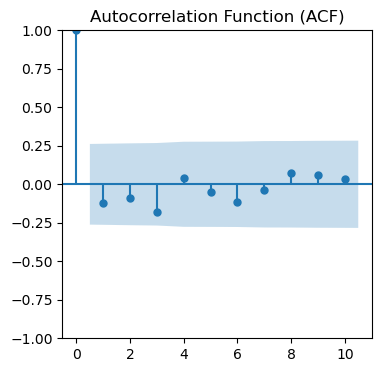

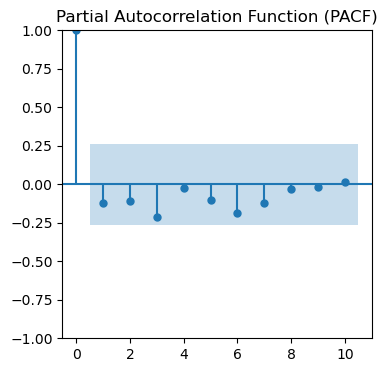

In [72]:
plt.figure(figsize=(4, 4))
plot_acf(reg_df['alpha_2'], lags=10, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(4, 4))
plot_pacf(reg_df['alpha_2'], lags=10, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [73]:
ljung_box_test = acorr_ljungbox(reg_df['alpha_2'], lags=[10], return_df=True)
print(ljung_box_test)

    lb_stat  lb_pvalue
10  5.38764   0.863826


                               SARIMAX Results                                
Dep. Variable:                alpha_2   No. Observations:                   56
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 163.790
Date:                Thu, 01 Aug 2024   AIC                           -317.580
Time:                        13:49:20   BIC                           -307.453
Sample:                             0   HQIC                          -313.654
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.146      0.252      -0.001       0.000
ar.L1          0.6752      0.239      2.821      0.005       0.206       1.144
ma.L1         -0.9532      0.940     -1.014      0.3

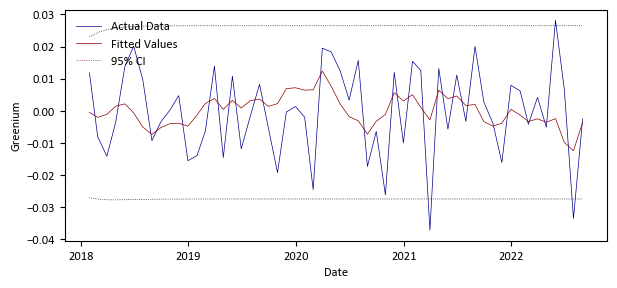

In [74]:
model = ARIMA(reg_df['alpha_2'], order=(1, 0, 2))
result = model.fit()

print(result.summary())

fitted_values = result.fittedvalues
rmse_arma = np.sqrt(mean_squared_error(reg_df['alpha_2'][1:], fitted_values[1:]))
print("RMSE (ARMA):", rmse_arma)

mean_value = reg_df['alpha_2'].mean()
mean_predictions = np.full_like(reg_df['alpha_2'], fill_value=mean_value)
rmse_baseline = np.sqrt(mean_squared_error(reg_df['alpha_2'], mean_predictions))
print("RMSE (Baseline - Mean Prediction):", rmse_baseline)

rmse_comparison_df = pd.DataFrame({
    'Model': ['ARMA(1,0,2)', 'Baseline (Mean Prediction)'],
    'RMSE': [rmse_arma, rmse_baseline]
})
rmse_comparison_df.to_csv('rmse_comparison.csv', index=False)

forecast = result.get_forecast(steps=len(reg_df))
ci = forecast.conf_int(alpha=0.05)  # 95% CI

plt.figure(figsize=(7, 3))
sns.lineplot(x=reg_df['dates'], y=reg_df['alpha_2'], label='Actual Data', color='darkblue', linewidth=0.5)
sns.lineplot(x=reg_df['dates'], y=fitted_values, label='Fitted Values', color='darkred', linewidth=0.5)

plt.plot(reg_df['dates'], ci.iloc[:, 0], color='black', linestyle='dotted', linewidth=0.5, label='95% CI Lower')
plt.plot(reg_df['dates'], ci.iloc[:, 1], color='black', linestyle='dotted', linewidth=0.5, label='95% CI Upper')

plt.xlabel('Date', fontsize=9, fontname='Calibri')
plt.ylabel('Greenium', fontsize=9, fontname='Calibri')

legend_elements = [
    Line2D([0], [0], color='darkblue', linewidth=0.5, label='Actual Data'),
    Line2D([0], [0], color='darkred', linewidth=0.5, label='Fitted Values'),
    Line2D([0], [0], color='darkred', linestyle='dotted', linewidth=0.5, label='95% CI')
]

legend = plt.legend(handles=legend_elements, loc='upper left', fontsize=9, frameon=False)
plt.setp(legend.get_texts(), fontsize=9, fontname='Calibri')
plt.xticks(fontsize=9, fontname='Calibri')
plt.yticks(fontsize=9, fontname='Calibri')
plt.grid(False)
plt.show()

In [75]:
returns = reg_df['alpha_2'].dropna()  

arma_models = ['ARMA(0,1)', 'ARMA(0,2)', 'ARMA(1,0)', 'ARMA(1,1)', 'ARMA(1,2)', 'ARMA(2,0)', 'ARMA(2,1)', 'ARMA(2,2)']

# Prepare DataFrame to store results
arma_results = pd.DataFrame(columns=['Model', 'AIC', 'BIC', 'LogLikelihood'])

# Fit each ARMA model and store results
for model_name in arma_models:
    try:
        arma_order = tuple(map(int, model_name[5:-1].split(',')))
        model = ARIMA(returns, order=(arma_order[0], 0, arma_order[1]))
        fit = model.fit()
        aic = fit.aic
        bic = fit.bic
        log_likelihood = fit.llf
        arma_results = arma_results.append({'Model': model_name, 'AIC': aic, 'BIC': bic, 'LogLikelihood': log_likelihood}, ignore_index=True)
    except Exception as e:
        print(f"Model {model_name} failed to fit: {e}")

print("ARMA Results:")
print(arma_results)


ARMA Results:
       Model         AIC         BIC  LogLikelihood
0  ARMA(0,1) -315.352702 -309.276647     160.676351
1  ARMA(0,2) -315.311443 -307.210036     161.655721
2  ARMA(1,0) -315.054843 -308.978788     160.527422
3  ARMA(1,1) -319.547027 -311.445621     163.773514
4  ARMA(1,2) -317.580206 -307.453448     163.790103
5  ARMA(2,0) -313.752784 -305.651377     160.876392
6  ARMA(2,1) -317.159047 -307.032288     163.579523
7  ARMA(2,2) -315.409953 -303.257843     163.704977


In [76]:
garch_models = ['GARCH(1,1)', 'GARCH(1,2)', 'GARCH(2,1)', 'GARCH(2,2)']

garch_results = pd.DataFrame(columns=['Model', 'AIC', 'BIC', 'LogLikelihood'])

for model_name in garch_models:
    try:
        garch_order = tuple(map(int, model_name[6:-1].split(',')))
        model = arch_model(returns, vol='Garch', p=garch_order[0], q=garch_order[1])
        fit = model.fit(disp='off')
        aic = fit.aic
        bic = fit.bic
        log_likelihood = fit.loglikelihood
        garch_results = garch_results.append({'Model': model_name, 'AIC': aic, 'BIC': bic, 'LogLikelihood': log_likelihood}, ignore_index=True)
    except Exception as e:
        print(f"Model {model_name} failed to fit: {e}")

print("GARCH Results:")
print(garch_results)


GARCH Results:
        Model         AIC         BIC  LogLikelihood
0  GARCH(1,1) -313.666490 -305.565083     160.833245
1  GARCH(1,2) -310.599426 -300.472667     160.299713
2  GARCH(2,1) -310.582268 -300.455510     160.291134
3  GARCH(2,2) -308.687683 -296.535573     160.343842


In [77]:
arma_garch_models = [
    'ARMA(1,0)-GARCH(1,1)', 'ARMA(1,0)-GARCH(1,2)', 'ARMA(1,0)-GARCH(2,1)', 'ARMA(1,0)-GARCH(2,2)',
    'ARMA(2,0)-GARCH(1,1)', 'ARMA(2,0)-GARCH(1,2)', 'ARMA(2,0)-GARCH(2,1)', 'ARMA(2,0)-GARCH(2,2)'
]

arma_garch_results = pd.DataFrame(columns=['Model', 'AIC', 'BIC', 'LogLikelihood'])

for model_name in arma_garch_models:
    try:
        arma_order = tuple(map(int, model_name.split('-')[0][5:-1].split(',')))
        garch_order = tuple(map(int, model_name.split('-')[1][6:-1].split(',')))
        model = arch_model(returns, mean='ARX', lags=arma_order[0], vol='Garch', p=garch_order[0], q=garch_order[1])
        fit = model.fit(disp='off')
        aic = fit.aic
        bic = fit.bic
        log_likelihood = fit.loglikelihood
        arma_garch_results = arma_garch_results.append({'Model': model_name, 'AIC': aic, 'BIC': bic, 'LogLikelihood': log_likelihood}, ignore_index=True)
    except Exception as e:
        print(f"Model {model_name} failed to fit: {e}")

print("ARMA-GARCH Results:")
print(arma_garch_results)


ARMA-GARCH Results:
                  Model         AIC         BIC  LogLikelihood
0  ARMA(1,0)-GARCH(1,1) -306.280592 -296.243927     158.140296
1  ARMA(1,0)-GARCH(1,2) -304.282687 -292.238688     158.141344
2  ARMA(1,0)-GARCH(2,1) -304.282695 -292.238696     158.141348
3  ARMA(1,0)-GARCH(2,2) -302.282681 -288.231349     158.141341
4  ARMA(2,0)-GARCH(1,1) -298.174733 -286.240829     155.087367
5  ARMA(2,0)-GARCH(1,2) -296.166298 -282.243409     155.083149
6  ARMA(2,0)-GARCH(2,1) -296.174743 -282.251855     155.087371
7  ARMA(2,0)-GARCH(2,2) -294.174760 -278.262888     155.087380


# Generalized Mathematical Model

cek hurst mean reverting 
poisson process


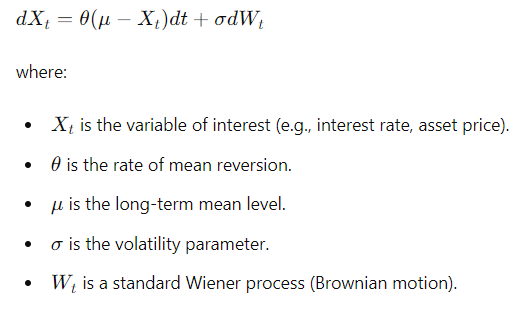

# Single Portfolio

In [78]:
reg_df.head()

,mcci_error,gmb_spread,pf_green,pf_brown,Mkt-RF,SMB,HML,dates,earnings_error,earnings_error_green,earnings_error_brown,alpha,alpha_2,alpha_2_cumsum,lower_ci_cumsum,upper_ci_cumsum,gmb_spread_cumsum
0,-0.130062,-0.000378,0.005477,0.005856,0.0552,0.0064,0.0110,2018-01-31,0.000000,0.000000,0.000000,0.012039,0.011853,0.011853,-0.006880,0.005588,-0.000378
1,0.349671,-0.000357,0.005499,0.005856,-0.0535,0.0110,-0.0075,2018-02-28,0.000000,0.000000,0.000000,-0.008553,-0.008053,0.003800,-0.013584,0.011018,-0.000735
2,0.109850,-0.009003,-0.006394,0.002609,-0.0071,-0.0056,-0.0094,2018-03-31,-0.082021,-0.051202,0.030819,-0.011581,-0.014157,-0.010357,-0.020112,0.016291,-0.009738
3,-0.203841,-0.005990,0.025543,0.031533,0.0220,-0.0070,0.0151,2018-04-30,0.000000,0.000000,0.000000,-0.003320,-0.003612,-0.013969,-0.026466,0.021409,-0.015728
4,0.228150,0.015868,-0.019018,-0.034886,-0.0273,0.0107,-0.0498,2018-05-31,0.000000,0.000000,0.000000,0.013376,0.013702,-0.000267,-0.032649,0.026375,0.000140


In [79]:
returns = reg_df['alpha_2'].values

# OU Process: dX_t = theta * (mu - X_t) * dt + sigma * dW_t
def ou_log_likelihood(params, data):
    theta, mu, sigma = params
    X = data
    n = len(X)
    
    dt = 1  
    dX = np.diff(X)
    X_t = X[:-1]
    
    variance = sigma ** 2 * dt
    if np.any(variance == 0):
        return np.inf
    
    mean_reversion = theta * (mu - X_t) * dt
    
    log_likelihood = -0.5 * np.sum((dX - mean_reversion) ** 2 / variance + np.log(2 * np.pi * variance))
    
    return -log_likelihood  # Negative because we minimize

initial_params = [0.1, np.mean(returns), np.std(returns)]
bounds = [(0, None), (None, None), (0, None)]

result = minimize(ou_log_likelihood, initial_params, args=(returns,), method='L-BFGS-B', bounds=bounds)

theta_hat, mu_hat, sigma_hat = result.x

hessian_inv = result.hess_inv.todense()  

standard_errors = np.sqrt(np.diag(hessian_inv))

t_statistics = result.x / standard_errors

log_likelihood_value = -result.fun

k = 3  # theta, mu, sigma

n = len(returns)

AIC = 2 * k - 2 * log_likelihood_value
BIC = k * np.log(n) - 2 * log_likelihood_value

df = n - k

p_values = 2 * (1 - t_dist.cdf(np.abs(t_statistics), df))

print(f"Theta (mean reversion rate): {theta_hat}")
print(f"Mu (long-term mean): {mu_hat}")
print(f"Sigma (volatility): {sigma_hat}")
print(f"Standard Errors: {standard_errors}")
print(f"T-statistics: {t_statistics}")
print(f"P-values: {p_values}")
print(f"Log-Likelihood: {log_likelihood_value}")
print(f"AIC: {AIC}")
print(f"BIC: {BIC}")

Theta (mean reversion rate): 1.1228466677573046
Mu (long-term mean): -0.0005794663573820876
Sigma (volatility): 0.013790836641335976
Standard Errors: [1.5983624  0.01193597 0.00636386]
T-statistics: [ 0.70249818 -0.04854789  2.16705557]
P-values: [0.48544264 0.96146209 0.03474512]
Log-Likelihood: 157.56462398884358
AIC: -309.12924797768716
BIC: -303.0531929054817


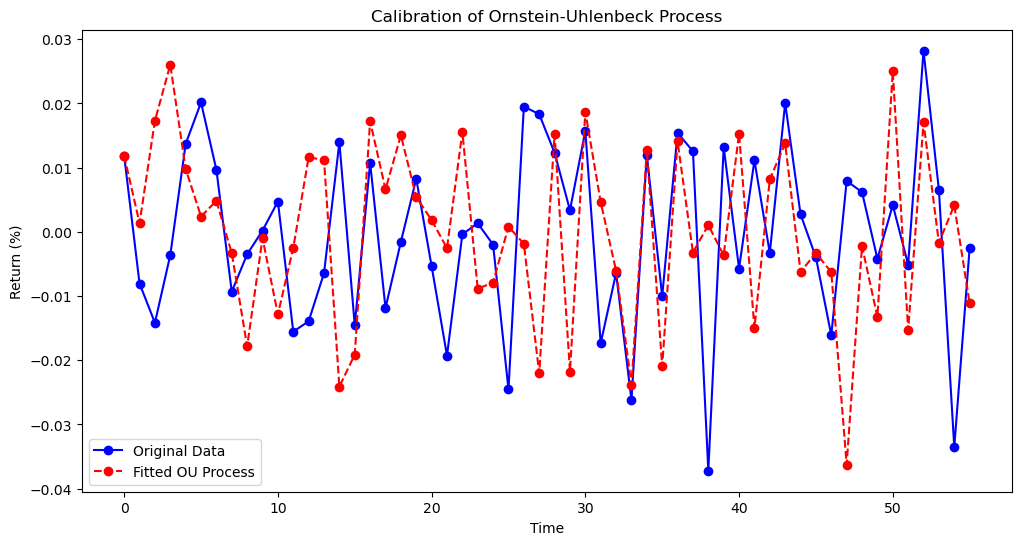

In [80]:
def simulate_ou_process(theta, mu, sigma, X0, n_steps):
    dt = 1 
    X = np.zeros(n_steps)
    X[0] = X0
    for t in range(1, n_steps):
        X[t] = X[t-1] + theta * (mu - X[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    return X

n_steps = len(returns)
X0 = returns[0]

simulated_ou = simulate_ou_process(theta_hat, mu_hat, sigma_hat, X0, n_steps)

plt.figure(figsize=(12, 6))
plt.plot(range(n_steps), returns, label='Original Data', marker='o', color='blue')
plt.plot(range(n_steps), simulated_ou, label='Fitted OU Process', marker='o', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Return (%)')
plt.title('Calibration of Ornstein-Uhlenbeck Process')
plt.legend()
plt.show()

Mu (drift rate): -0.9127895992811684
Sigma (volatility): 4.169759449386326
Standard Errors: [0.60148349 0.31177654]
T-statistics: [-1.51756384 13.37419256]
P-values: [0.13495747 0.        ]
Log-Likelihood: 108.51377701112474
AIC: -213.0275540222495
BIC: -208.9768506407792


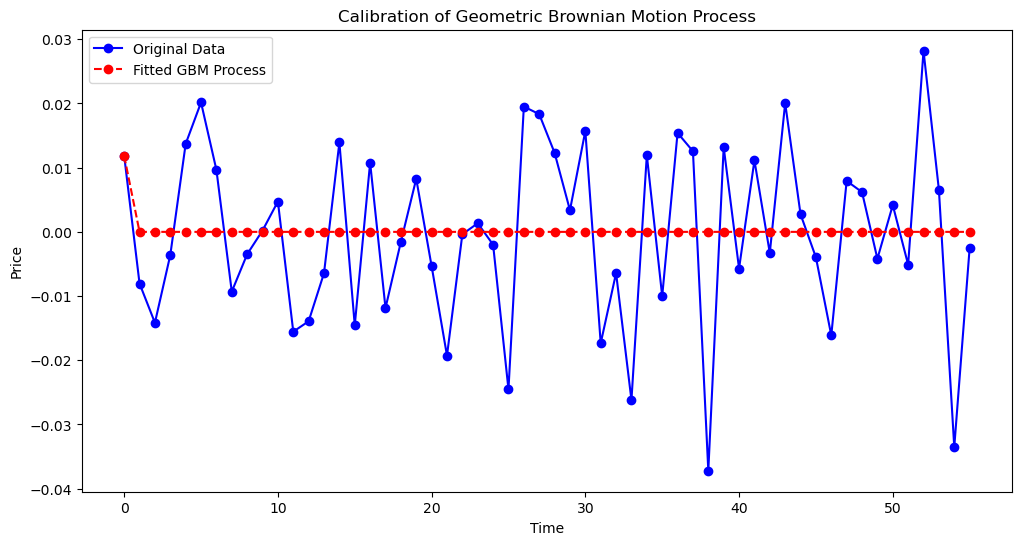

In [81]:
prices = reg_df['alpha_2'].values

# GBM Process: dS_t = mu * S_t * dt + sigma * S_t * dW_t
def gbm_log_likelihood(params, data):
    mu, sigma = params
    S = data
    n = len(S)
    
    dt = 1  
    dS = np.diff(S)
    S_t = S[:-1]
    
    variance = (sigma ** 2) * (S_t ** 2) * dt
    if np.any(variance <= 0):
        return np.inf
    
    mean_component = mu * S_t * dt
    
    log_likelihood = -0.5 * np.sum(((dS - mean_component) ** 2 / variance) + np.log(2 * np.pi * variance))
    
    return -log_likelihood 

initial_params = [0.1, np.std(prices)]
bounds = [(None, None), (1e-5, None)]  # Ensure sigma > 0

result = minimize(gbm_log_likelihood, initial_params, args=(prices,), method='L-BFGS-B', bounds=bounds)

mu_hat, sigma_hat = result.x

hessian_inv = result.hess_inv.todense()  

standard_errors = np.sqrt(np.diag(hessian_inv))

t_statistics = result.x / standard_errors

log_likelihood_value = -result.fun

k = 2  # mu, sigma

n = len(prices)

AIC = 2 * k - 2 * log_likelihood_value
BIC = k * np.log(n) - 2 * log_likelihood_value

df = n - k

p_values = 2 * (1 - t_dist.cdf(np.abs(t_statistics), df))

print(f"Mu (drift rate): {mu_hat}")
print(f"Sigma (volatility): {sigma_hat}")
print(f"Standard Errors: {standard_errors}")
print(f"T-statistics: {t_statistics}")
print(f"P-values: {p_values}")
print(f"Log-Likelihood: {log_likelihood_value}")
print(f"AIC: {AIC}")
print(f"BIC: {BIC}")

# Generate the fitted GBM process using the estimated parameters
def simulate_gbm_process(mu, sigma, S0, n_steps):
    dt = 1  # Assuming time step is 1 for simplicity
    S = np.zeros(n_steps)
    S[0] = S0
    for t in range(1, n_steps):
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.normal())
    return S

n_steps = len(prices)
S0 = prices[0]

simulated_gbm = simulate_gbm_process(mu_hat, sigma_hat, S0, n_steps)

# Plot the original data and the fitted GBM process
plt.figure(figsize=(12, 6))
plt.plot(range(n_steps), prices, label='Original Data', marker='o', color='blue')
plt.plot(range(n_steps), simulated_gbm, label='Fitted GBM Process', marker='o', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Calibration of Geometric Brownian Motion Process')
plt.legend()
plt.show()